In [ ]:
# MEMORY CLEAN
# import gc
# gc.collect()
from IPython import get_ipython
get_ipython().run_line_magic('reset',  '-sf')

In [45]:
# Restart script
import os
import sys

def restart_program():
    """Restarts the current program, with file objects and descriptors cleanup"""
    try:
        p = psutil.Process(os.getpid())
        for handler in p.get_open_files() + p.connections():
            os.close(handler.fd)
    except Exception as e:
        logging.error(e)
    python = sys.executable
    os.execl(python, python, *sys.argv)

In [46]:
# IMPORT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error

In [68]:
# DATA WRANGLER
# path1 = os.path.join("openbiomechanics", "baseball_pitching", "data", "metadata.csv")
# meta_data = pd.read_csv(path1)
# path2 = os.path.join("openbiomechanics", "baseball_pitching", "data", "full_sig", "forces_moments.csv")
# data = pd.read_csv(path2)
# path3 = os.path.join("openbiomechanics", "baseball_pitching", "data", "full_sig", "force_plate.csv")
# force_data = pd.read_csv(path3)
# path4 = os.path.join("openbiomechanics", "baseball_pitching", "data", "poi", "poi_metrics.csv")
# poi = pd.read_csv(path4)

## MAC IMPORT
# In DrivelinePython
meta_data = pd.read_csv('originalmetadata.csv')
data = pd.read_csv('forces_moments.csv')
poi = pd.read_csv('poi_metrics.csv')

# data.groupby('session_pitch').count()
# force_data.groupby('session_pitch').count()
# meta_data.groupby('session_pitch').count()

# Filter by pitch speed, sort by ID num
meta_data = meta_data[meta_data.pitch_speed_mph >= 89].sort_values(by=['session_pitch'], ascending=True)
meta_data['session_pitch'] = meta_data['session_pitch'].str.replace('_', '.', regex=False)
poi['session_pitch'] = poi['session_pitch'].str.replace('_', '.', regex=False)
# Filter session ID by first trial (..._1)
filt_meta_data = meta_data[meta_data['session_pitch'].str.endswith('1')]
constr_data = pd.merge(filt_meta_data[['session_pitch']], data, on='session_pitch', how='left')
constr_poi = pd.merge(filt_meta_data[['session_pitch']], poi, on='session_pitch', how='left')
constr_poi.drop(columns=['session', 'p_throws', 'pitch_type', 'session_pitch', 'pitch_speed_mph'], inplace=True)
reg_poi = constr_poi.copy()
reg_poi.drop(columns=['elbow_varus_moment'], inplace=True)


In [69]:
# STATISTICS
mean_age = np.mean(filt_meta_data.age_yrs)
std_age = np.std(filt_meta_data.age_yrs)
mean_height = np.mean(filt_meta_data.session_height_m)
std_height = np.std(filt_meta_data.session_height_m)
mean_mass = np.mean(filt_meta_data.session_mass_kg)
std_mass = np.std(filt_meta_data.session_mass_kg)
# filt_meta_data['playing_level_num'] = filt_meta_data['playing_level'].replace({'college': 1, 'independent': 2, 'milb': 3})
val_counts = filt_meta_data['playing_level'].value_counts()
rel_dist = filt_meta_data['playing_level'].value_counts(normalize=True)
playing_levels = pd.DataFrame({'Playing Level': val_counts.index, 'Amount': val_counts.values, 'Relative Distribution (%)': rel_dist.values * 100})

descriptives_table = {
	'Descriptive': ['Age (years)', 'Height (m)', 'Mass (kg)'],
	'Mean': [mean_age, mean_height, mean_mass],
	'Std Dev': [std_age, std_height, std_mass]
}

# Decide Split for "injury risk" qualification (quartiles may constrain sample too much)
median = np.median(constr_poi.elbow_varus_moment)
varus = pd.DataFrame({
	'varus': (constr_poi.elbow_varus_moment > median).astype(int)
})
# low_varus = constr_poi[constr_poi.elbow_varus_moment <= median]
# high_varus = constr_poi[constr_poi.elbow_varus_moment > median]

In [70]:
# CART
# Regression Tree Features
features = reg_poi.columns.tolist()
remove_features = ['']
features = [f for f in features if f not in remove_features]

# Classification
# poi_train_class, poi_test_class, varus_train_class, varus_test_class = train_test_split(constr_poi, varus, test_size=0.2, random_state=42)
# clf = DecisionTreeClassifier(random_state=42)
# clf.fit(poi_train_class, varus_train_class)
# varus_pred = clf.predict(poi_test_class)
# accuracy = accuracy_score(varus_test_class, varus_pred)
# print(f"Classification accuracy: {accuracy:.2f}")

# Regression
poi_train, poi_test, varus_train, varus_test = train_test_split(reg_poi, varus, test_size=0.2, random_state=42)
reg = DecisionTreeRegressor(
	random_state=42,
	max_depth=3,			# Tree complexity
	min_samples_split=5,	# Require > 5 samples to split
	min_samples_leaf=3		# Require > 3 samples per leaf
	) 
reg.fit(poi_train, varus_train)
varus_pred = reg.predict(poi_test)
mse = mean_squared_error(varus_test, varus_pred)
print(f"Regression MSE: {mse:.2f}")

# Cross Validation
cv_scores = cross_val_score(reg, reg_poi[features], varus,
						 cv=21,
						 scoring='neg_mean_squared_error')
print(f"CV MSE: {-cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# CHECK
print(reg.feature_importances_)
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(poi_train, varus_train)
print(f"Intercept: {lm.intercept_}")
print(f"Coefficients: {dict(zip(poi_train.columns, lm.coef_))}")
print(f"R²: {lm.score(poi_train, varus_train):.4f}")

Regression MSE: 0.60
CV MSE: 0.15 ± 0.35
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Intercept: [-4.59235238]
Coefficients: {'max_shoulder_internal_rotational_velo': array([ 4.81893129e-04, -8.51234129e-04,  1.00762538e-03, -7.56887022e-05,
       -2.14282084e-05,  2.66455790e-04,  3.36588486e-05,  1.11069474e-03,
       -1.22589370e-04,  4.78908897e-04,  3.72625422e-04, -5.46660007e-04,
        1.33970312e-03, -4.88234290e-04, -3.72813564e-04,  8.64331468e-06,
        1.23928879e-04,  1.82329286e-07,  9.51538727e-05, -1.34205254e-04,
       -9.06523418e-05, -4.72535079e-06,  2.69030327e-04,  3.10618879e-04,
       -6.34738538e-05, -1.15989948e-04,  2.44547156e-04, -5.29996186e-05,
        1.09256239e-04, -6.91190984e-05, -3.88281907e-04,  1.61988061e-04,
        6.11485926e-04, -1.50785975e-04, -4.2449

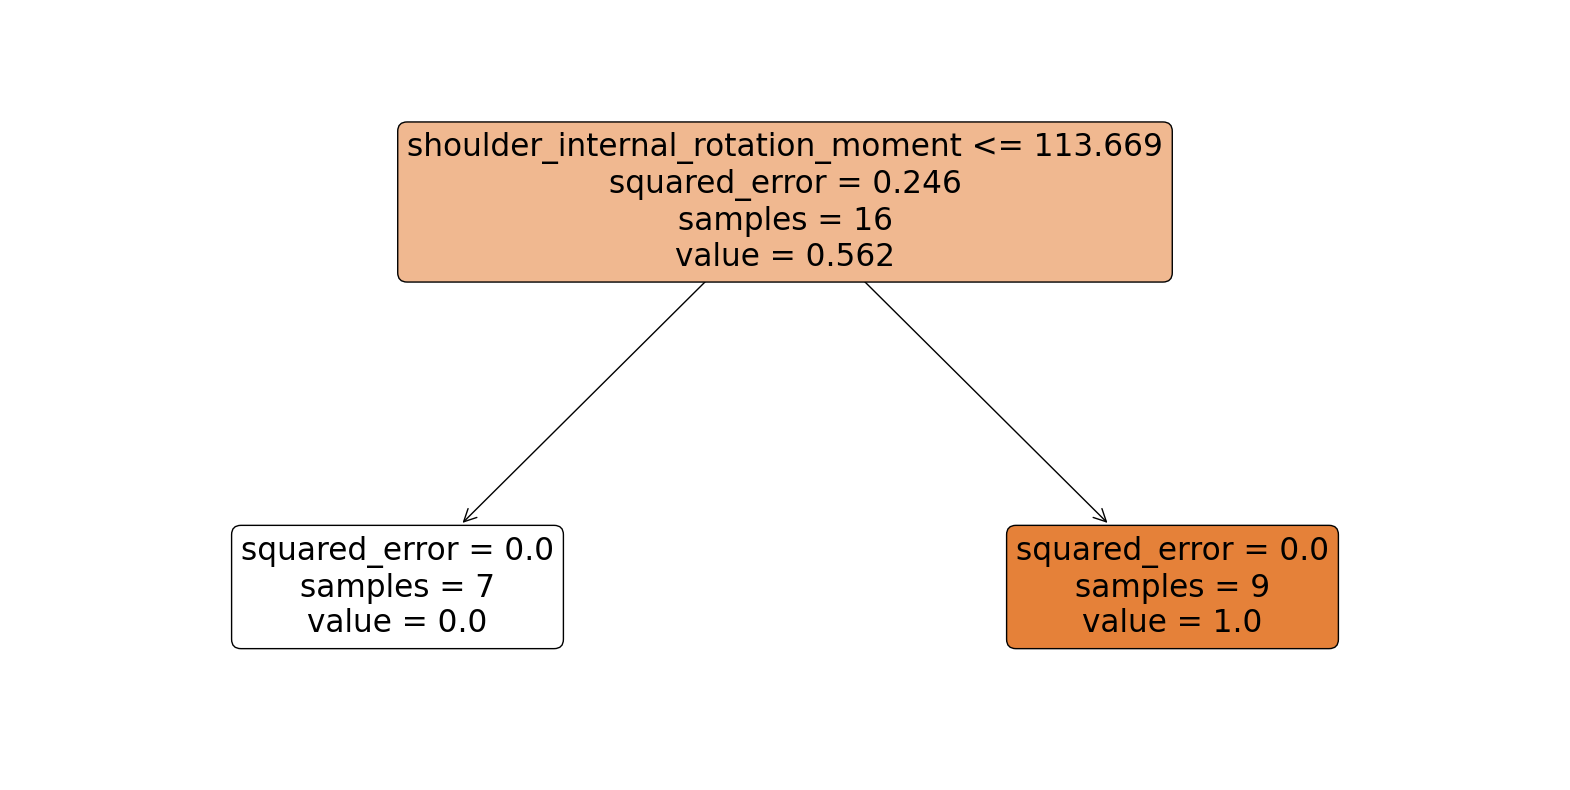

In [71]:
# Visualize
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(reg, feature_names=features, filled=True, rounded=True)
plt.show()

# Comments, first output:
# Max shoulder internal rotation velocity is the largest indicator of elbow varus torque (EVT).
# True Branch: Pitchers with lower MIR velo will have lower EVT. 
# False Branch: Pitchers with  higher MIR velo will have higher EVT.
# New model? Train based on proximal/distal influence (i.e. begin with lead knee kinematics)